In [ ]:
import numpy as np

## RNN

아래 RNN class는 한 개의 시점에서 RNN이 작동하는 방식을 구현

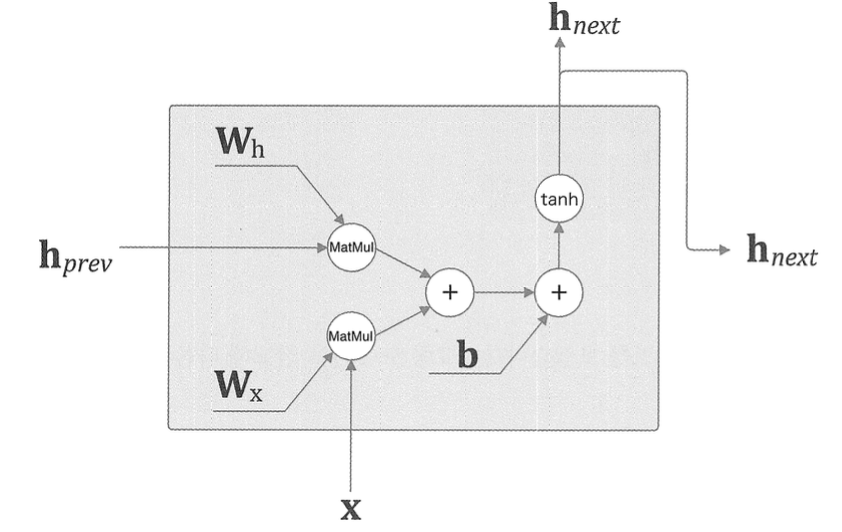


In [ ]:
class RNN:
  def __init__(self, Wx, Wh, b):
    self.params = [Wx,Wh,b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
    self.cache = None # 캐시값

  def forward(self, x, h_prev):
    Wx, Wh, b = self.params

    """
    문제 1: hidden state를 update할 때 행렬곱 연산을 한 후 더하는 과정에서 "이것"을 같이 더해줍니다.
    "이것"에 해당하는 것을 채워넣어주세요.

    bias 를 더해줘야 함
    """
    t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
    h_next = np.tanh(t)

  def backward(self, dh_next):
    Wx, Wh, b = self. params
    x, h_prev, h_next = self.cache
    dt = dh_next * (1 - h_next ** 2)
    db = np.sum(dt, axis=0)

    """
    문제 2: 가중치 행렬 Wh의 gradient인 dWh는 전치행렬과 미분된 행렬의 행렬곱 형태로 표현됩니다.
    matmul() 함수에 적절한 값을 넣어주세요.

    chain rule 로 인해 계산된 dWh 값은 아래와 같음
    """
    dWh = np.matmul(h_prev.T, dt)
    dh_prev = np.matmul(dt, Wh.T)
    dWx = np.matmul(x.T, dt)
    dx = np.matmul(dt, Wx.T)
    self.grads[0][...] = dWx
    self.grads[1][...] = dWh
    self.grads[2][...] = db
    return dx, dh_prev

## TIME RNN
이번에는 한 시점에서만이 아닌, T개의 time step이 주어졌을 때의 RNN layer를 살펴보도록 합시다.

"밑바닥부터 시작하는 딥러닝" 216p를 참고하세요!

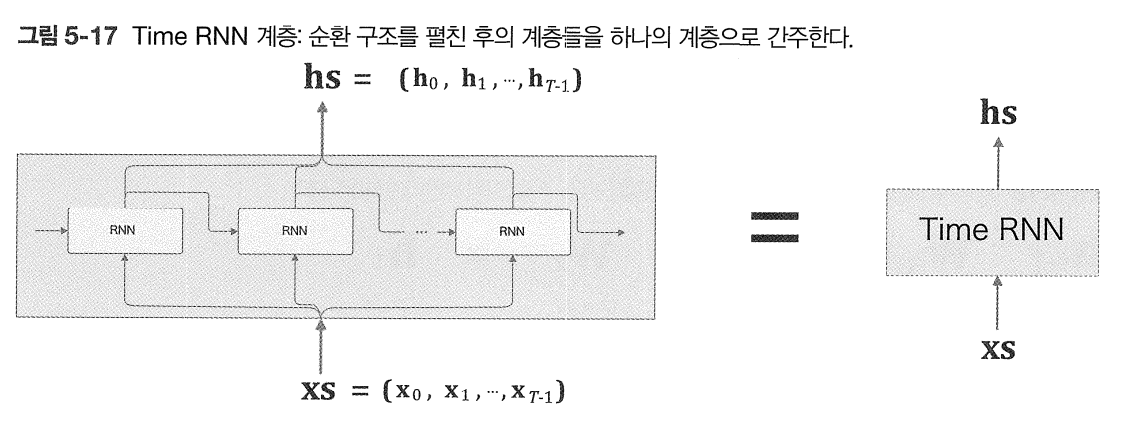



T개의 단계분을 한번에 처리하는 층

In [ ]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None  # 여러 time steps의 RNN cell을 리스트로 저장

        self.h = None # forward() 진행 시 마지막 RNN cell의 hidden state
        self.dh = None # backward() 진행 시 하나 앞 블록의 hidden state의 gradient
        self.stateful = stateful # False일 경우 hidden state를 영행렬로 초기화함

    def set_state(self, h):
        '''hidden state(h)를 설정하는 메서드'''
        self.h = h

    def reset_state(self):
        '''hidden state(h)를 초기화하는 메서드'''
        self.h = None

    def forward(self, xs):
        '''input으로 받는 xs는 T개 분량의 시계열 데이터'''
        Wx, Wh, b = self.params
        N, T, D = xs.shape  # N(batch), T(time steps), D(input size)
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None: # stateful=False or 처음 호출 시
            self.h = np.zeros((N, H), dtype='f') # hidden state가 영행렬로 초기화됨

        for t in range(T):
            layer = RNN(*self.params) # 앞서 구성한 RNN class를 갖고옴

            """
            문제3: 이 반복문은 각 time step별로 RNN의 forward 메서드를 실행하고 있습니다.
            그렇다면 input으로 들어갈 xs의 2번째 차원은 무엇이 되어야 할까요?

            t 값을 진행시키며 계산해 간다.

            """
            self.h = layer.forward(xs[:, t, :], self.h)

            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):  # dhs 에 대한 역전파를 수행 및 입력값에 대한 gradient 반환
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')  # T개 분량의 시계열 데이터
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):  # 역순으로 진행
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)  # 합산된 기울기
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

## LSTM

In [ ]:
class sigmoid:
    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        return dx

In [ ]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape # hidden state 벡터 차원 수 (batch_size, 노드 수)

        # 총 4개의 게이트에서의 아핀 변환을 한 번에 계산
        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        f = A[:, :H]          # forget gate 얼마나 잊어버릴지
        g = A[:, H:2*H]       # input gate 새 정보를 얼마나 누적할지 (-1 : 1)
        i = A[:, 2*H:3*H]     # input gate 새 정보를 얼마나 누적할지 (0 : 1)
        o = A[:, 3*H:]        # input, forget gate 값들을 다음단계로 전달

        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)


        """
        문제4: LSTM의 cell state를 구하기 위해 "빈칸"에 들어갈 적절한 값들을 채워넣어주세요.
        """
        c_next = f * c_prev + g * i


        """
        문제5: LSTM의 t 시점(next 시점) hidden state를 구하기 위한 공식은 무엇이었나요?
        해당 공식을 생각해보고 "빈칸"에 들어갈 적절한 값을 채워넣어주세요.

        매 시점 다른 게이트 값을 가짐
        """
        h_next = o * np.tanh(c_next)

        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        tanh_c_next = np.tanh(c_next)

        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        dc_prev = ds * f

        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        dA = np.hstack((df, dg, di, do))

        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev